[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MouseLand/rastermap/blob/main/notebooks/tutorial.ipynb)


# What to do with thousands of neurons in cortex?

We will use a spontaneous activity recording from [Syeda et al, 2023](https://www.biorxiv.org/content/10.1101/2022.11.03.515121v1.abstract). We recorded 34,086 neurons from mouse sensorimotor cortex for 2+ hours using two-photon calcium imaging at a rate of 3.2Hz. FYI to make the download of the dataset faster, we are analyzing only the first half of the recording. During the recording, the mouse was free to run on an air floating ball, and we recorded the mouse face with a camera at a rate of 50Hz and tracked keypoints on the mouse face.

First we will install the required packages, if not already installed. If on google colab, it will require you to click the "RESTART RUNTIME" button because we are updating numpy. Also if you are on google colab, select the GPU runtime if you want to fit the neural network to predict neural activity from behaviors:
**Runtime > Change runtime type > Hardware accelerator = GPU**

In [1]:
!pip install numpy>=1.24 # (required for google colab)
!pip install rastermap
!pip install matplotlib
!pip install neuropop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

# 1. Loading and preparing.

Import the Python libraries

In [2]:
import os # os stands for "operating system" and includes read/write routines etc.
import numpy as np # by far the most used library for everyday computation
from scipy import stats # here we import a whole sub-library of stats functions
from matplotlib import pyplot as plt # all of our plotting is done with plt
%matplotlib inline
# %matplotlib notebook # if you need to zoom into a figure, this is the "interactive" mode of IPython

from rastermap import utils, Rastermap

# download the spontaneous activity recording
filename = utils.download_data(data_type="spont2")

# load the neural data and the processed behavioral data
dat = np.load(filename)
spks, U, sv, V = dat["spks"], dat["U"], dat["sv"], dat["V"]
xpos, ypos = dat["xpos"], dat["ypos"]
tcam, tneural = dat["tcam"], dat["tneural"]
run, beh, beh_names = dat["run"], dat["beh"], dat["beh_names"]

n_neurons, n_time = spks.shape

print(f"{n_neurons} neurons by {n_time} timepoints")

# we will z-score each neuron so that the activity is standard deviation 1 and mean 0 for each neuron
spks = stats.zscore(spks, axis=1)

# colors for the behaviors
kp_colors = np.array([[0.55,0.55,0.55], [0.,0.,1],
                      [0.8,0,0], [1.,0.4,0.2],
                      [0,0.6,0.4], [0.2,1,0.5],
                      ])


100%|██████████| 1.81G/1.81G [01:51<00:00, 17.5MB/s]


34086 neurons by 14000 timepoints


# 2. Visualizing neural activity with Rastermap

Let's first look at the positions of the neurons.

(np.float64(-350.6),
 np.float64(5269.666666666666),
 np.float64(-246.13333333333335),
 np.float64(5374.133333333333))

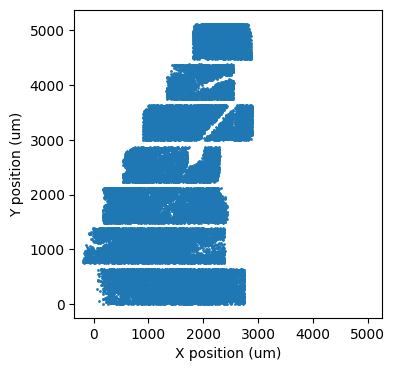

In [3]:
# POSITIONS OF ALL NEURONS
plt.figure(figsize=(4, 4))
plt.scatter(ypos, xpos, s = 1)
plt.xlabel('X position (um)')
plt.ylabel('Y position (um)')
plt.axis("square")

Now let's run Rastermap. Rastermap re-arranges neurons in the raster plot based on similarity of activity.

In [4]:
from rastermap import Rastermap

### run rastermap
model = Rastermap(n_clusters=100, n_PCs=128, locality=0.6,
                  time_lag_window=5).fit(spks)
cc_nodes = model.cc.copy()
isort = model.isort

Let's create superneurons from Rastermap: sort the data and then sum over neighboring neurons.

In [5]:
nbin = 200 # number of neurons to bin over
ndiv = (n_neurons//nbin) * nbin
# group sorted matrix into rows of length nbin
sn = spks[isort][:ndiv].reshape(ndiv//nbin, nbin, -1)
# take mean over neurons in a bin
sn = sn.mean(axis=1)

Let's visualize the activity

(np.float64(-0.5), np.float64(0.5), np.float64(169.5), np.float64(-0.5))

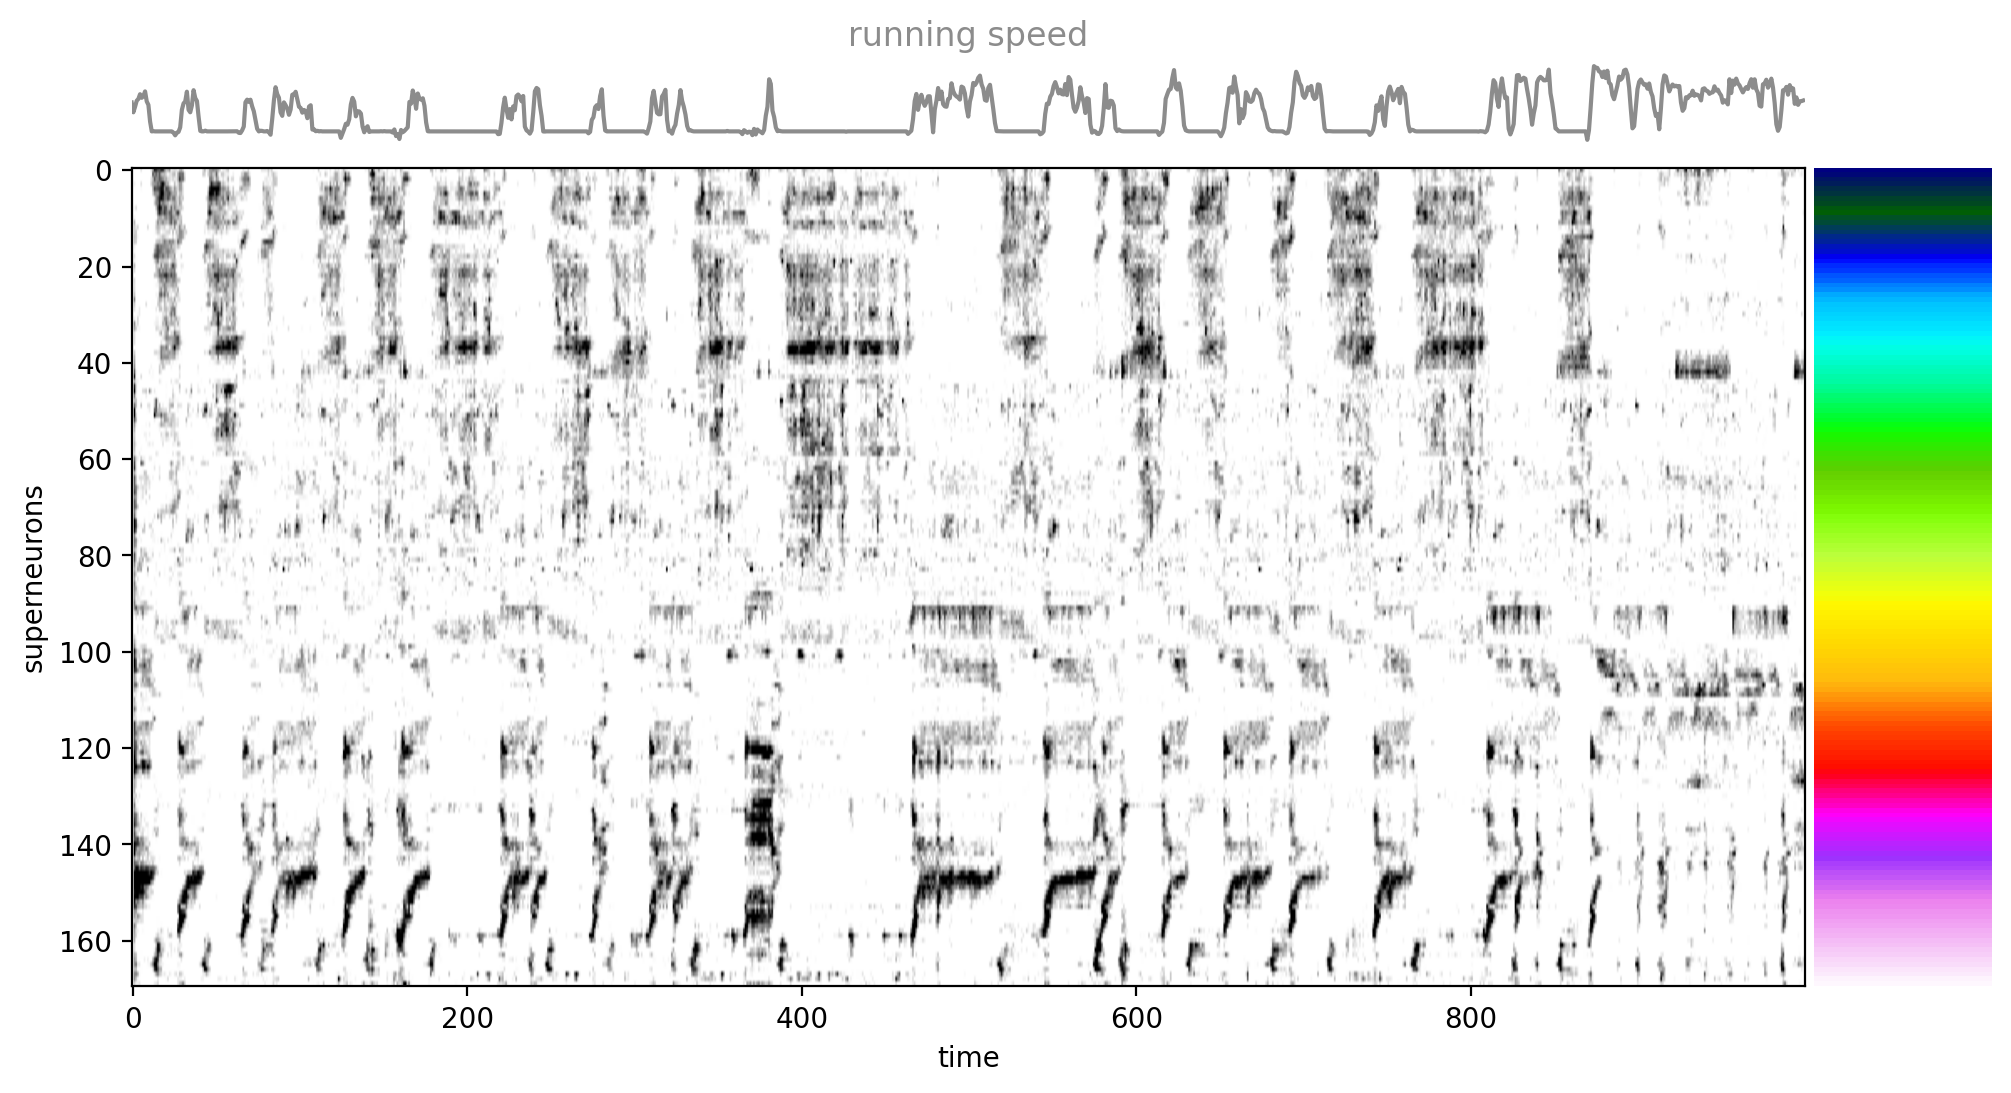

In [6]:
# timepoints to visualize
xmin = 0
xmax = xmin + 1000

fig = plt.figure(figsize=(12,6), dpi=200)
grid = plt.GridSpec(9, 10, figure=fig, wspace = 0.05, hspace = 0.3)

# plot running speed
ax = plt.subplot(grid[0, :-1])
ax.plot(run[xmin:xmax], color=kp_colors[0])
ax.set_xlim([0, xmax-xmin])
ax.axis("off")
ax.set_title("running speed", color=kp_colors[0])

# plot superneuron activity
ax = plt.subplot(grid[1:, :-1])
ax.imshow(sn[:, xmin:xmax], cmap="gray_r", vmin=0, vmax=0.8, aspect="auto")
ax.set_xlabel("time")
ax.set_ylabel("superneurons")

ax = plt.subplot(grid[1:, -1])
ax.imshow(np.arange(0, len(sn))[:,np.newaxis], cmap="gist_ncar", aspect="auto")
ax.axis("off")


color the neurons by their position in the rastermap

(np.float64(-350.6),
 np.float64(5269.666666666666),
 np.float64(-246.13333333333335),
 np.float64(5374.133333333333))

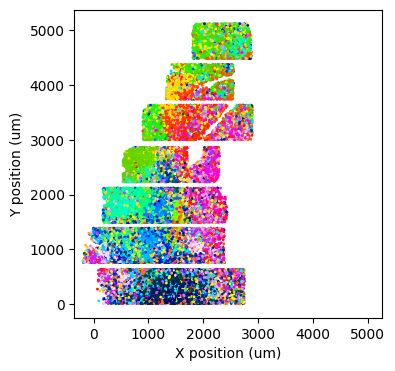

In [7]:
# POSITIONS OF ALL NEURONS
plt.figure(figsize=(4, 4))
plt.scatter(ypos, xpos, s = 1, c=model.embedding[:,0], cmap="gist_ncar")
plt.xlabel('X position (um)')
plt.ylabel('Y position (um)')
plt.axis("square")

# 2. Dimensionality reduction: what are the dominant patterns of activity?

Let's compute the top PCs

In [8]:
from sklearn.decomposition import TruncatedSVD

# this function returns the left singular vectors scaled by the singular values
Vsv = TruncatedSVD(n_components = 128).fit_transform(spks.T)

# compute the other singular vectors
U = spks @ (Vsv / (Vsv**2).sum(axis=0)**0.5)
U /= (U**2).sum(axis=0)**0.5

plot the PCs in time

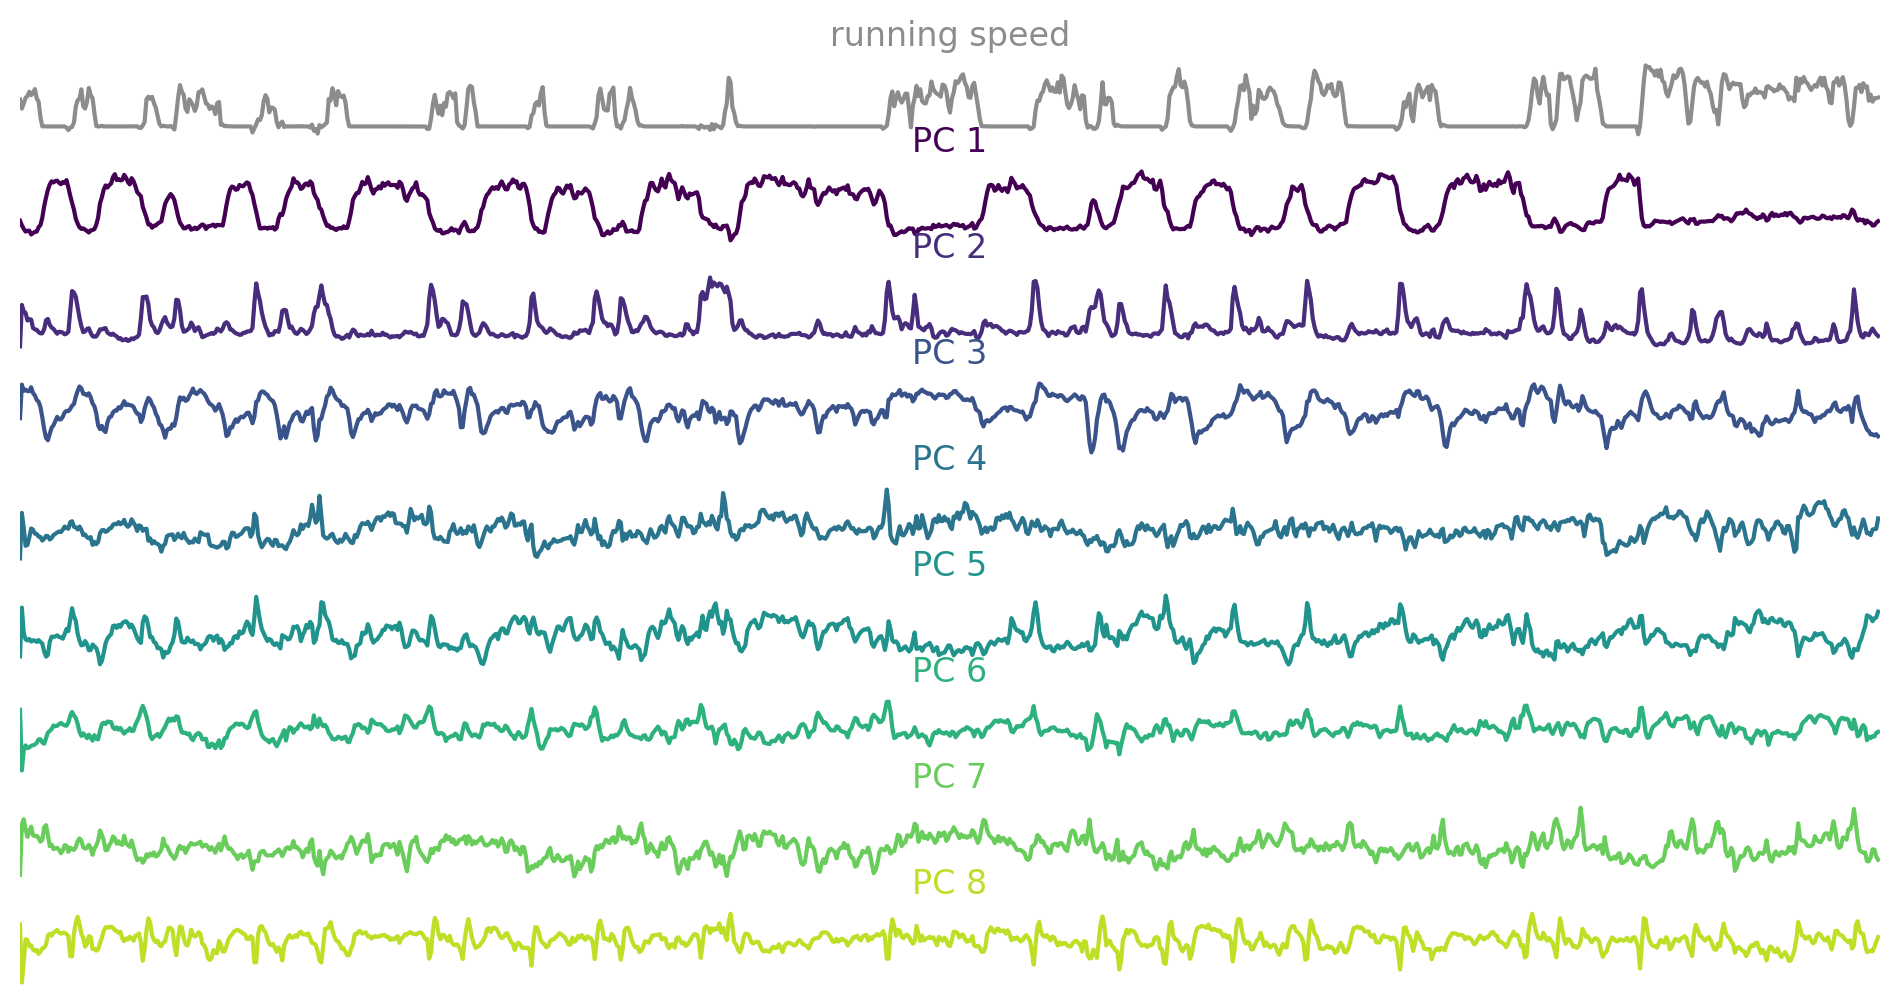

In [9]:
fig = plt.figure(figsize=(12,6), dpi=200)
grid = plt.GridSpec(9, 1, figure=fig, hspace = 0.4)

# plot running speed
ax = plt.subplot(grid[0, 0])
ax.plot(run[xmin:xmax], color=kp_colors[0])
ax.set_xlim([0, xmax-xmin])
ax.axis("off")
ax.set_title("running speed", color=kp_colors[0])

pc_colors = plt.get_cmap("viridis")(np.linspace(0,0.9,8))
for j in range(8):
    ax = plt.subplot(grid[j+1])
    ax.plot(Vsv[xmin:xmax, j], color=pc_colors[j])
    ax.set_xlim([0, xmax-xmin])
    ax.axis("off")
    ax.set_title(f"PC {j+1}", color=pc_colors[j])


we will predict the PCs from the behavior (many fewer of them)

# 3. Behavioral analysis

We will figure out the sorts of behaviors the superneurons care about!

The behavioral video is at 50Hz while the neural data is at 3.2 Hz.

Here are the behaviors we tracked:

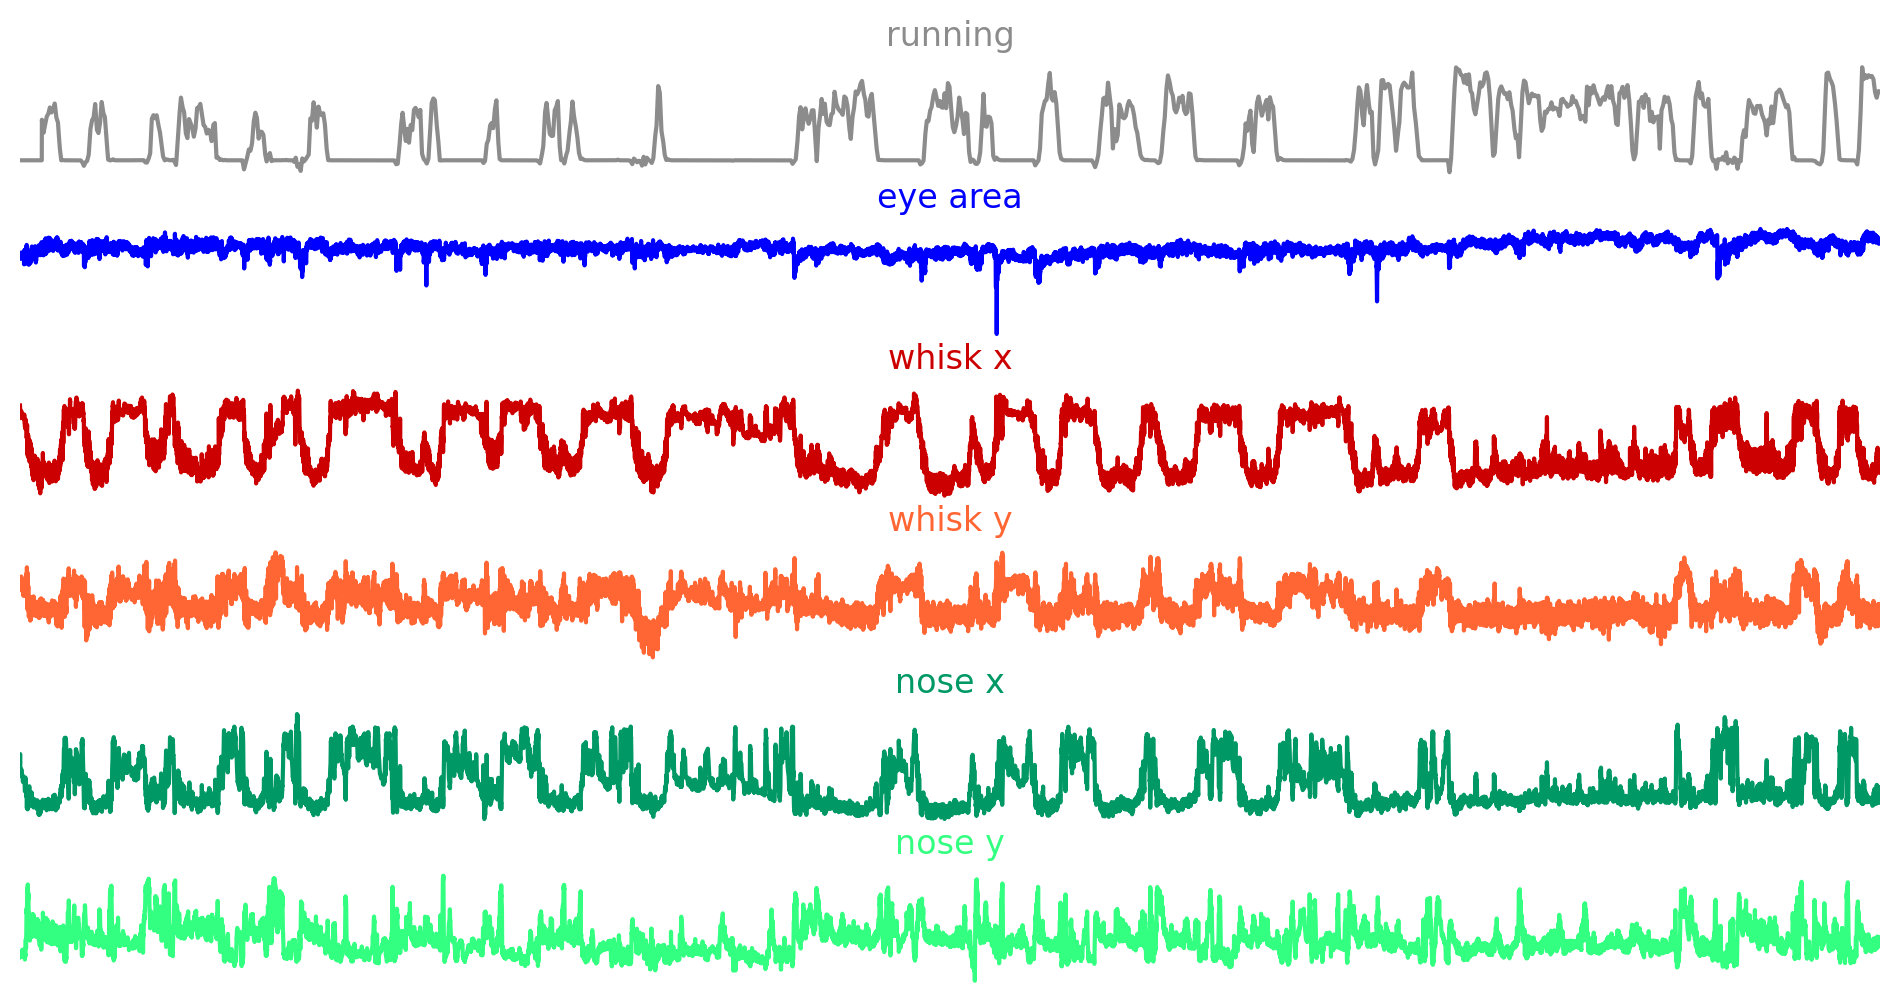

In [10]:
fig = plt.figure(figsize=(12,6), dpi=200)
grid = plt.GridSpec(len(beh_names), 1, figure=fig, hspace = 0.4)

n_beh = beh.shape[1]
for j in range(n_beh):
    ax = plt.subplot(grid[j])
    ax.plot(beh[17*xmin:17*xmax, j], color=kp_colors[j])
    ax.set_xlim([0, 17*(xmax-xmin)])
    ax.axis("off")
    ax.set_title(beh_names[j], color=kp_colors[j])


Since the sampling rate and timing of neural activity and the behavior are different, we will first downsample the behavior data to the timestamps of the neural activity.

The easiest way to do this is with interpolation: we know when in time each behavior frame happened (`tcam`), and then we sample it at each time the neural activity happened (`tneural`). But there are a lot of fast things going on in the behavior, so to get the average over timepoints at the neural activity time, we smooth the behavioral data first.

In [11]:
from scipy.ndimage import gaussian_filter1d # here we import a smoothing function
from scipy.interpolate import interp1d # importing an interpolation function

# initialize empty matrix
beh_ds = np.zeros((len(tneural), n_beh), "float32")

for j in range(n_beh):
    # filter the data
    # (smoothing scale proportional to difference in sampling rate)
    bsmooth = gaussian_filter1d(beh[:,j], 50/3.2)
    # interpolate
    f = interp1d(tcam, bsmooth)
    beh_ds[:,j] = f(tneural)

print(beh_ds.shape)

(14000, 6)


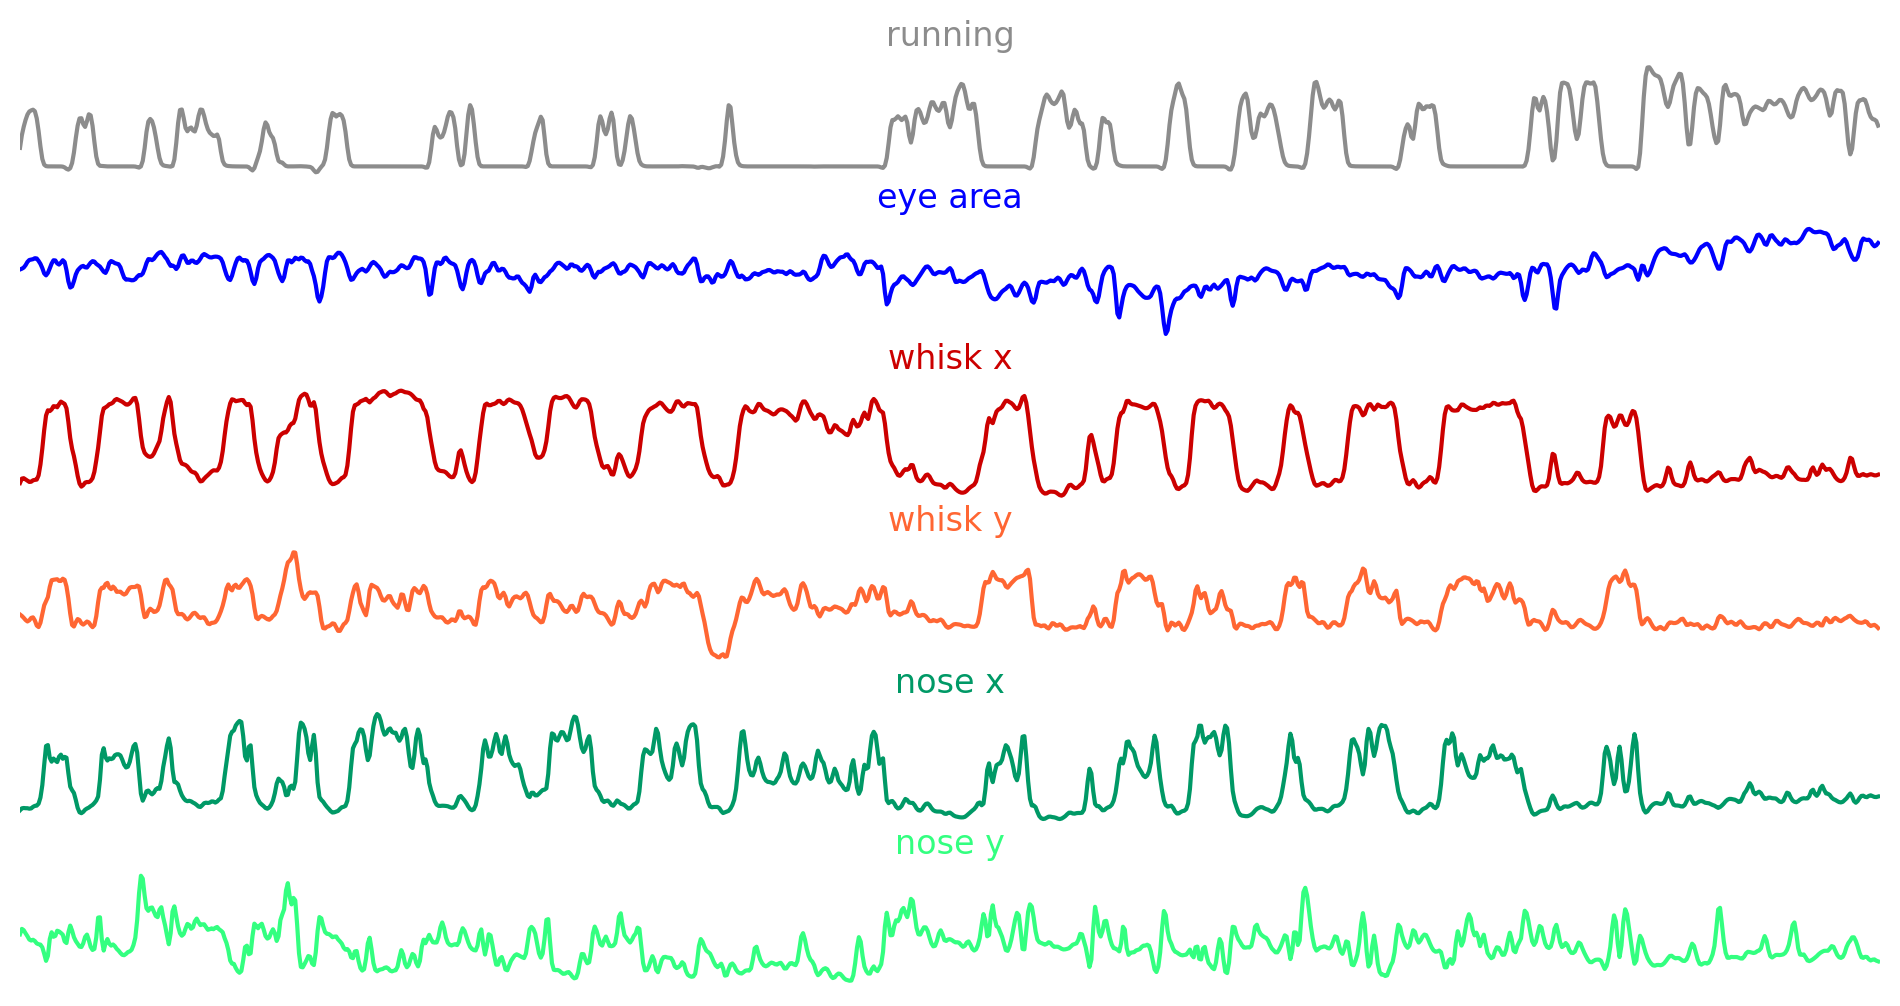

In [12]:
# plot the traces again
fig = plt.figure(figsize=(12,6), dpi=200)
grid = plt.GridSpec(len(beh_names), 1, figure=fig, hspace = 0.4)
for j in range(n_beh):
    ax = plt.subplot(grid[j])
    ax.plot(beh_ds[xmin:xmax, j], color=kp_colors[j])
    ax.set_xlim([0, (xmax-xmin)])
    ax.axis("off")
    ax.set_title(beh_names[j], color=kp_colors[j])


Now, to do prediction, we have to do a train-test split. You always want to train your model on a subset of data and test its performance on another set

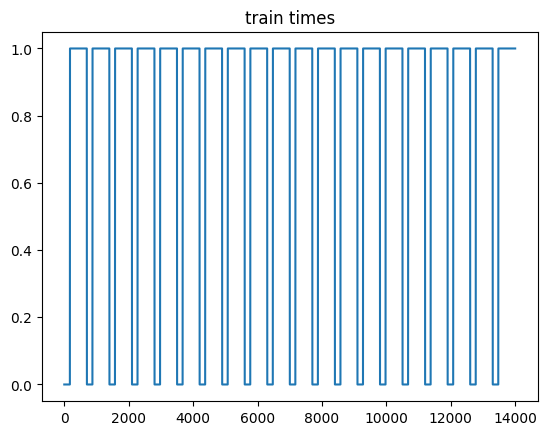

In [13]:
# split into train-test
# * use interleaved segments *
n_segs = 20
n_len  = n_time / n_segs
sinds = np.linspace(0, n_time - n_len, n_segs).astype(int)
itest = (sinds[:,np.newaxis] + np.arange(0, n_len*0.25, 1, int)).flatten()
itrain = np.ones(n_time, "bool")
itrain[itest] = 0
itest = ~itrain

plt.plot(itrain)
plt.title("train times")
plt.show()

Can you determine how I did the split above? Why might I have split into segments rather than randomly interleaving time-points?

## Linear regression prediction

Use linear regression to perform the prediction, predict PCs $Y$ using behaviors $X$:

$$ A = (X_\text{train}^\top X_\text{train})^{-1} (X_\text{train}^\top Y_\text{train})$$

$X$ is behavioral components by time, $Y$ is neural components by time. If you want to regularize the linear regression:

$$ A = (X_\text{train}^\top X_\text{train} + \lambda I)^{-1} (X_\text{train}^\top Y_\text{train})$$

Then the prediction on time points is:

$$ \hat Y_\text{test} = X_\text{test} A $$

In [14]:
## predict using behavior traces
# regularized linear regression from behavior to neural PCs

XtX = beh_ds[itrain].T @ beh_ds[itrain]
XtY = beh_ds[itrain].T @ Vsv[itrain]
lam = 1e1 # regularizer
XtX += lam * np.eye(n_beh)

# regression matrix
A = np.linalg.solve(XtX, XtY)

# prediction
Vpred = beh_ds[itest] @ A

# variance explained per PC
residual = ((Vpred - Vsv[itest])**2).sum(axis=0)
varexp_PC = 1 - residual / (Vsv[itest]**2).sum(axis=0)

# overall varexp
varexp = 1 - residual.sum() / (Vsv[itest]**2).sum()

print(f"overall variance explained = {varexp}")

overall variance explained = 0.18250054121017456


plot PCs and prediction

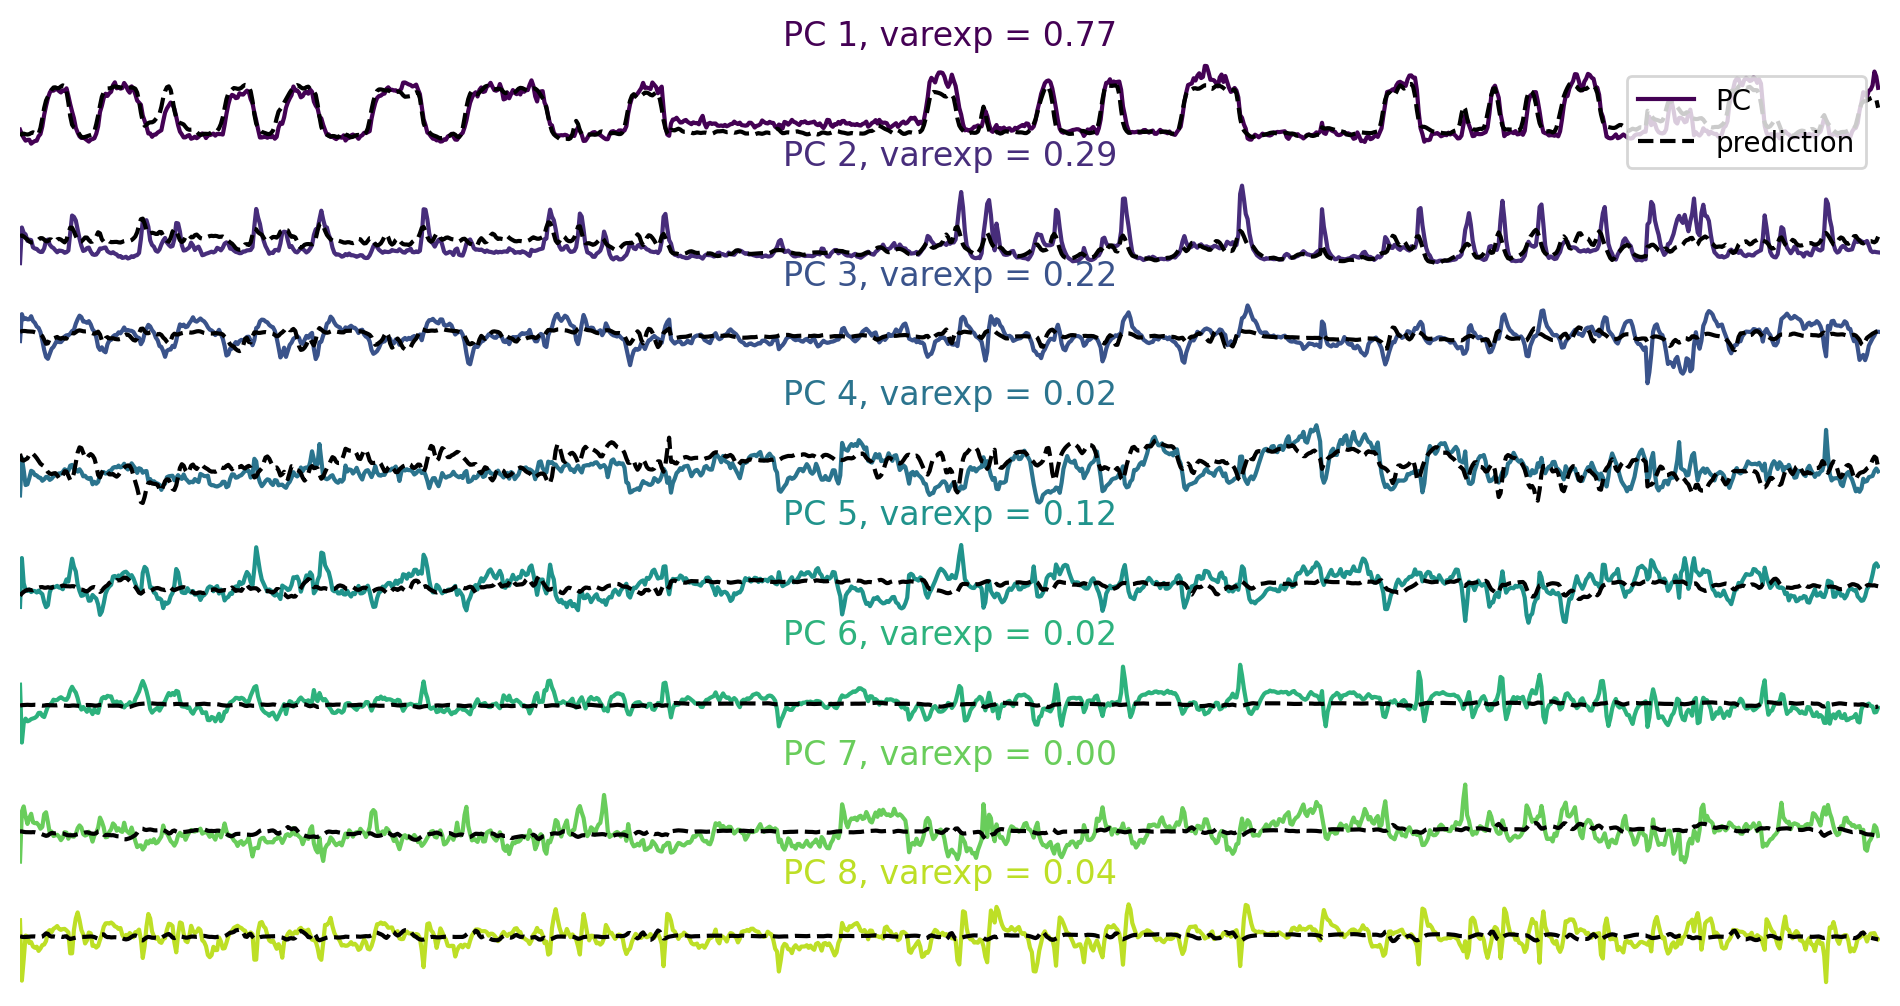

In [15]:
fig = plt.figure(figsize=(12,6), dpi=200)
grid = plt.GridSpec(8, 1, figure=fig, hspace = 0.4)

for j in range(8):
    ax = plt.subplot(grid[j])
    ax.plot(Vsv[itest][xmin:xmax, j], color=pc_colors[j])
    ax.plot(Vpred[xmin:xmax, j], color="k", linestyle="--")
    ax.set_xlim([0, xmax-xmin])
    ax.axis("off")
    ax.set_title(f"PC {j+1}, varexp = {varexp_PC[j]:.2f}", color=pc_colors[j])
    if j==0:
        ax.legend(["PC", "prediction"], loc="upper right")

## Predicting with a 1D convolution layer

There are finer temportal features in the behavioral features that we aren't capturing by smoothing and using the smoothed traces.

Instead we can learn the temporal features by using a 1D convolution layer with various filters -- called kernels.

See below a nice illustration of a convolution from this [webpage](https://e2eml.school/convolution_one_d.html). This kernel is a gaussian, you can see how it smooths the data. But a neural network can learn whatever kernels help with prediction.

![conv_gif](https://e2eml.school/images/conv1d/stride_1.gif)

We will use **pytorch** for this. It allows us to write a network and then it automatically finds the gradients to optimize it to our data.

We will create a model with a linear input layer, a one-dimensional convolutional layer, and a linear output layer.

In [17]:
from neuropop import nn_prediction
import torch

# ideally we have a GPU we can use ("cuda" option)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

# declare the model
pred_model = nn_prediction.PredictionNetwork(n_in=beh.shape[-1], n_kp=22, identity=False,
                                             n_filt=10, n_latents=0,
                                             n_out=Vsv.shape[-1], n_core_layers=1,
                                             relu_wavelets=False, relu_latents=False)
# put model on the GPU
pred_model.to(device);

print(pred_model)

cpu
PredictionNetwork(
  (core): Core(
    (features): Sequential(
      (linear0): Sequential(
        (0): Linear(in_features=6, out_features=22, bias=True)
      )
      (wavelet0): Conv1d(1, 10, kernel_size=(201,), stride=(1,), padding=(100,), bias=False)
    )
  )
  (readout): Readout(
    (linear): Sequential(
      (0): Linear(in_features=220, out_features=128, bias=True)
    )
  )
)


You should see the layers, can you figure out what some of these variables mean?

Now let's train the model with a function we have that includes the data splitting and the gradient descent. We will see the variance explained on each iteration.

In [19]:
y_pred_all, ve_all, itest = pred_model.train_model(beh, Vsv, tcam, tneural, delay=-1,
                                                    learning_rate=1e-3, n_iter=50,
                                                    device=device, verbose=True)
Vpred_conv = y_pred_all
itest = itest.flatten() # we run using batches of data so we now flatten it

# variance explained per PC
residual = ((Vpred_conv - Vsv[itest])**2).sum(axis=0)
varexp_PC_conv = 1 - residual / (Vsv[itest]**2).sum(axis=0)


epoch 0, animal 0, train loss 26.1531, test loss 27.4178, varexp 0.2673, time 5.2s
epoch 20, animal 0, train loss 25.0948, test loss 26.8845, varexp 0.2815, time 93.4s
epoch 40, animal 0, train loss 24.8691, test loss 26.7183, varexp 0.2859, time 181.6s
epoch 49, animal 0, train loss 24.8772, test loss 26.6946, varexp 0.2866, time 221.4s


This fit better! Let's see what the prediction looks like, it seems like the higher PCs are better captured especially.

In [ ]:
fig = plt.figure(figsize=(12,6), dpi=200)
grid = plt.GridSpec(8, 1, figure=fig, hspace = 0.4)

for j in range(8):
    ax = plt.subplot(grid[j])
    ax.plot(Vsv[itest][xmin:xmax, j], color=pc_colors[j])
    ax.plot(Vpred_conv[xmin:xmax, j], color="k", linestyle="--")
    ax.set_xlim([0, xmax-xmin])
    ax.axis("off")
    ax.set_title(f"PC {j+1}, varexp = {varexp_PC_conv[j]:.2f}", color=pc_colors[j])
    if j==0:
        ax.legend(["PC", "prediction"], loc="upper right")

## Receptive fields of superneurons

We can use this linear model to estimate the receptive fields of the superneurons.

First we need to get the superneuron PC weights.

In [ ]:
# sort and bin PCs for maxstim estimation
U_sn = U[isort][:ndiv].reshape(ndiv//nbin, nbin, -1).mean(axis=1)

print(U_sn.shape)

In [ ]:
ms_model = nn_prediction.MaxStimModel(pred_model)
ms_model.requires_grad = False
u = torch.from_numpy(U_sn).to(device)
u.requires_grad = False
xr = ms_model.train_batch(u, n_iter=200, learning_rate=1e-2)
rfs = xr.detach().cpu().numpy()

print(rfs.shape)

Visualize a subset of receptive fields

In [ ]:
fig = plt.figure(figsize=(12,6), dpi=200)
grid = plt.GridSpec(12, 21, figure=fig, wspace = 0.05, hspace = 0.0)

vmax = 8
ks = np.linspace(5, len(U_sn)-5, 12*3).astype("int")
for i, k in enumerate(ks):
    for j in range(n_beh):
        ax = plt.subplot(grid[i%12, j + 6*(i//12) + (i//12)])
        ax.plot(rfs[k, 100:-100, j], color=kp_colors[j])
        ax.set_ylim([-vmax, vmax])
        ax.axis("off")
        if i==0:
            ax.set_title(beh_names[j], color=kp_colors[j], rotation=45)



Visualize the receptive fields with the data

In [ ]:
# timepoints to visualize
xmin = 0
xmax = xmin + 1000

fig = plt.figure(figsize=(12,6), dpi=200)
grid = plt.GridSpec(9, 18, figure=fig, wspace = 0.35, hspace = 0.3)

# plot running speed
ax = plt.subplot(grid[0, :12])
ax.plot(run[xmin:xmax], color=kp_colors[0])
ax.set_xlim([0, xmax-xmin])
ax.axis("off")
ax.set_title("running speed", color=kp_colors[0])

# plot superneuron activity
ax = plt.subplot(grid[1:, :12])
ax.imshow(sn[:, xmin:xmax], cmap="gray_r", vmin=0, vmax=0.8, aspect="auto")
ax.set_xlabel("time")
ax.set_ylabel("superneurons")

for j in range(n_beh):
    ax = plt.subplot(grid[1:, j+12])
    ax.imshow(rfs[:,100:-100,j], aspect="auto", vmin=-vmax, vmax=vmax, cmap="RdBu_r")
    ax.axis("off")
    ax.set_title(beh_names[j], color=kp_colors[j], rotation=45)


## Nonlinear prediction with 1D convolutions

We can put non-linearities in our neural network models to better model non-linear aspects of the data. We also add another layer to make it more complex. The network below is the default network from the Facemap paper.

In [ ]:
pred_model = nn_prediction.PredictionNetwork(n_in=beh.shape[-1], n_kp=22,
                                             n_out=Vsv.shape[-1])
# put model on the GPU
pred_model.to(device);

print(pred_model)

Train model

In [ ]:

y_pred_all, ve_all, itest = pred_model.train_model(beh, Vsv, tcam, tneural, delay=-1,
                                                        learning_rate=1e-3, n_iter=400,
                                                    device=device, verbose=True)
Vpred_nl = y_pred_all
itest = itest.flatten() # we run using batches of data so we now flatten it

# variance explained per PC
residual = ((Vpred_nl - Vsv[itest])**2).sum(axis=0)
varexp_PC_nl = 1 - residual / (Vsv[itest]**2).sum(axis=0)

Visualize the prediction. Remember we need to project using the PCs into the neuron space.

In [ ]:
sn_pred = U_sn @ Vpred_nl.T


fig = plt.figure(figsize=(12,12), dpi=200)
grid = plt.GridSpec(13, 1, figure=fig, wspace = 0.35, hspace = 0.6)

# plot running speed
ax = plt.subplot(grid[0, 0])
ax.plot(run[itest][xmin:xmax], color=kp_colors[0])
ax.set_xlim([0, xmax-xmin])
ax.axis("off")
ax.set_title("running speed", color=kp_colors[0])

# plot superneuron activity
ax = plt.subplot(grid[1:7, 0])
ax.imshow(sn[:, itest][:, xmin:xmax], cmap="gray_r", vmin=0, vmax=0.85, aspect="auto")
ax.set_ylabel("superneurons")
ax.set_xticks([])
ax.set_title("neural activity")

# plot superneuron prediction
ax = plt.subplot(grid[7:, 0])
ax.imshow(sn_pred[:, xmin:xmax], cmap="gray_r", vmin=0, vmax=0.85, aspect="auto")
ax.set_xlabel("time")
ax.set_ylabel("superneurons")
ax.set_title("behavior prediction")